<a href="https://colab.research.google.com/github/Glasiermedic/Massachusetts-Schools/blob/master/Mass_Schooling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Massachusetts School System
## Analysis prediction

### Data Exploration
#### I am very interested in identifying the current contributing factors for graduation rates, college admission test scores and 4 yr. college attendance rates in Massachusetts schools.  In this project I will first identity any trends or notable statistics around the variables. 

### Data cleaning and preparation
#### I will filter out features that add no value to the prediction like the school name, street address and city name.  I will also address any features that contain missing or placeholder data.  I will fit the data to a scale allowing the models to be more effective, utlize a correlation matrix and a random forest algorithm to determine the feature importance and if needed use Boruta to refine our features down to a managable and efficient set.  

### Modeling and model validation. 
#### As a part of the project I will define our exact question we will answer, identify the metric we will measure and create a model for predicting the outcome of our metric.  

##### Data used for this project came from the repository on Kaggle posted by [Nigel Dalziel](https://www.kaggle.com/ndalziel/massachusetts-public-schools-data#MA_Public_Schools_2017.csv).  Data compiled from [Massachusetts Department of Education ]http://profiles.doe.mass.edu/state_report/)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
#!pip install boruta
!pip3 install seaborn==0.9.0

#from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler 
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

from sklearn.ensemble import RandomForestRegressor
#from boruta import boruta_py
from sklearn import ensemble
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_predict

import warnings
warnings.filterwarnings('ignore')

In [0]:
mass_ed = pd.read_csv("https://raw.githubusercontent.com/Glasiermedic/Massachusetts-Schools/master/MA_Public_Schools_2017.csv", thousands = ",")

In [4]:
mass_ed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1861 entries, 0 to 1860
Columns: 302 entries, School Code to District_Progress and Performance Index (PPI) - High Needs Students
dtypes: float64(267), int64(19), object(16)
memory usage: 4.3+ MB


In [0]:
for i in range(0,len(mass_ed['School Type'])):
  if (mass_ed['School Type'][i]) == 'Public School':
    mass_ed.at[i,'School Type']= 0
  else: 
    mass_ed.at[i,'School Type']= 1


In [6]:
mass_ed['School Type'].unique()

array([0, 1], dtype=object)

In [0]:
import re

def multiple_replacer(*key_values):
    replace_dict = dict(key_values)
    replacement_function = lambda match: replace_dict[match.group(0)]
    pattern = re.compile("|".join([re.escape(k) for k, v in key_values]), re.M)
    return lambda string: pattern.sub(replacement_function, string)

def multiple_replace(string, *key_values):
    return multiple_replacer(*key_values)(string)
  
  
replacements = (' ','_'), ('%', 'percent'), ('#', 'num'), ('(1-99)', "")
#Example:  multiple_replace("Sales % with #people", *replacements))

In [0]:
ed_col = []
ed_columns =[]
for col in mass_ed.columns:
  ed_col.append(multiple_replace(col, *replacements))
for item in ed_col:
  ed_columns.append(item.lower())
#print(ed_columns) 

In [0]:
mass_ed = mass_ed.replace(np.NAN, 0)

In [0]:
mass_ed.columns = ed_columns

In [0]:
mass_ed = mass_ed.drop(['school_code', 'function', 'contact_name', 'address_1', 'address_2', 'town', 'state', 'zip', 'phone', 'fax', 'grade', 'district_name', 'district_code'], axis = 1)

In [12]:
%%time 

def data_preprocess(x):
  if (x['1_enrollment'] > 1) and (x['11_enrollment']> 1) and (x['6_enrollment'] > 1):
    x['school_type'] = 0
  if (x['pk_enrollment'] > 1) and (x['1_enrollment'] < 1):
    x['school_type'] = 4  
  elif (x['9_enrollment'] +  x['10_enrollment'] +  x['11_enrollment'] +  x['12_enrollment']) > 1:
    x['school_type'] = 3
  elif (x['7_enrollment'] > 1):
    x['school_type'] = 2
  else:
    x['school_type'] = 1
  
  return x
  
  

#mass_ed_copy.apply(lambda x: x['1_enrollment'], axis=1)
mass_ed = mass_ed.apply(lambda x: data_preprocess(x), axis=1)

CPU times: user 618 ms, sys: 13.7 ms, total: 631 ms
Wall time: 633 ms


In [13]:
mass_ed_high = mass_ed.loc[mass_ed['school_type']==3]
mass_ed_high.describe()

,school_type,pk_enrollment,k_enrollment,1_enrollment,2_enrollment,3_enrollment,4_enrollment,5_enrollment,6_enrollment,7_enrollment,...,percent_mcas_10thgrade_english_w/f,mcas_10thgrade_english_stud._incl._num,mcas_10thgrade_english_cpi,mcas_10thgrade_english_sgp,mcas_10thgrade_english_incl._in_sgp(num),school_accountability_percentile_,progress_and_performance_index_(ppi)_-_all_students,progress_and_performance_index_(ppi)_-_high_needs_students,district_progress_and_performance_index_(ppi)_-_all_students,district_progress_and_performance_index_(ppi)_-_high_needs_students
count,386.0,386.000000,386.000000,386.000000,386.000000,386.000000,386.000000,386.000000,386.000000,386.000000,...,386.000000,386.000000,386.000000,386.000000,386.000000,386.000000,386.000000,386.000000,386.000000,386.00000
mean,3.0,0.207254,3.284974,3.443005,3.279793,3.243523,3.266839,5.813472,11.238342,19.733161,...,2.093264,162.007772,84.419430,41.791451,142.455959,42.800518,62.932642,54.668394,63.303109,59.15285
std,0.0,2.943370,18.244277,18.774067,18.416381,18.425780,18.326300,26.261946,34.546865,46.309224,...,3.997610,139.683678,32.499896,22.092660,122.546909,32.272848,30.528090,32.072303,17.752961,15.93982
min,3.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,3.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,55.500000,93.300000,35.125000,45.250000,11.250000,58.000000,47.000000,53.000000,54.00000
50%,3.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,120.500000,97.800000,46.750000,111.500000,42.000000,71.000000,65.000000,63.000000,57.00000
75%,3.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,260.250000,99.200000,56.750000,221.500000,71.000000,83.000000,76.000000,72.750000,68.00000
max,3.0,54.000000,178.000000,182.000000,183.000000,191.000000,191.000000,244.000000,242.000000,386.000000,...,44.000000,925.000000,100.000000,88.000000,757.000000,99.000000,100.000000,100.000000,100.000000,100.00000


In [14]:
mass_ed_high['percent_attending_college'].describe()

count    386.000000
mean      63.158808
std       30.580845
min        0.000000
25%       54.625000
50%       75.500000
75%       85.700000
max      100.000000
Name: percent_attending_college, dtype: float64

In [0]:
mass_ed_high = mass_ed_high[mass_ed_high.percent_attending_college != 0]

In [16]:
print ("most frequent precentage of college attendance: \n{} \n".format(mass_ed_high['percent_attending_college'].value_counts().head(10)))

print ("less frequent precentage of college attendance: \n{} \n".format(mass_ed_high['percent_attending_college'].value_counts().tail(10)))

most frequent precentage of college attendance: 
87.5    5
87.7    4
89.9    4
89.3    4
71.4    4
89.5    4
76.6    3
87.9    3
84.6    3
72.8    3
Name: percent_attending_college, dtype: int64 

less frequent precentage of college attendance: 
58.6    1
91.7    1
52.4    1
45.6    1
33.6    1
84.4    1
47.7    1
40.7    1
42.6    1
69.3    1
Name: percent_attending_college, dtype: int64 



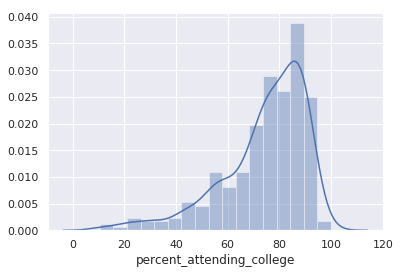

In [17]:
sns.distplot(mass_ed_high['percent_attending_college'])

### Selecting Features

In [18]:
X = mass_ed_high.drop(['high_school_graduates_(num)', 'percent_umass', 'percent_private_two-year', 'percent_public_two-year', 'percent_ma_community_college', 'percent_private_four-year', 'percent_mcas_10thgrade_english_a', 'percent_ma_state_university', 'attending_coll./univ._(num)', 'percent_public_four-year', 'percent_attending_college', 'school_name', 'high_needs', 'economically_disadvantaged', 'percent_mcas_10thgrade_english_p+a', 'accountability_and_assistance_level', 'accountability_and_assistance_description', 'progress_and_performance_index_(ppi)_-_all_students', 'progress_and_performance_index_(ppi)_-_high_needs_students', 'district_accountability_and_assistance_level', 'district_accountability_and_assistance_description', 'district_progress_and_performance_index_(ppi)_-_all_students', 'district_progress_and_performance_index_(ppi)_-_high_needs_students'],axis =1)
#X = mass_ed_high.drop(['percent_attending_college'],axis =1)

y = mass_ed_high['percent_attending_college'] 
print(y.shape)
print (X.shape)

(328,)
(328, 266)


In [0]:
from sklearn.model_selection import KFold
kfolds = KFold(n_splits =5, random_state=1)

In [20]:
forest = RandomForestRegressor(max_depth=7,n_jobs=-1, random_state=1, n_estimators=100, verbose=0)
forest.fit(X, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=7,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

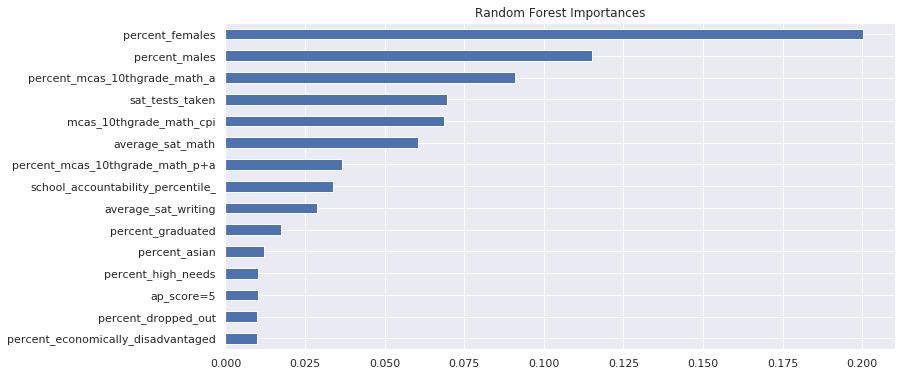

In [21]:
importances_for = forest.feature_importances_

indices = np.argsort(importances_for)[::-1]
for_imp_feat = []

for f in range(X.shape[1]):
    for_imp_feat.append(X.columns[indices[f]])

importances_df = pd.Series(importances_for, index=X.columns)
importances_df.nlargest(15).sort_values().plot(kind='barh', figsize=(12, 6)) 
plt.title("Random Forest Importances")
plt.show()

In [22]:
import xgboost as xgb
xg_reg_lin = xgb.XGBRegressor(objective ='reg:linear', 
                          learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
  nthread=4,
 scale_pos_weight=1, random_state =1)

xg_reg_lin.fit(X,y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
       nthread=4, objective='reg:linear', random_state=1, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.8)

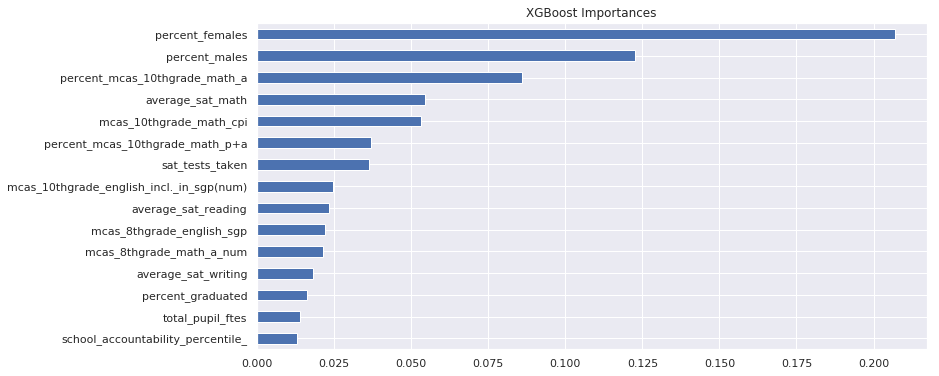

In [23]:
importances_xgb = xg_reg_lin.feature_importances_

indices = np.argsort(importances_xgb)[::-1]
xgb_imp_feat = []

for f in range(X.shape[1]):
    xgb_imp_feat.append(X.columns[indices[f]])

importances_df = pd.Series(importances_xgb, index=X.columns)
importances_df.nlargest(15).sort_values().plot(kind='barh', figsize=(12, 6)) 
plt.title("XGBoost Importances")
plt.show()


In [24]:
from sklearn import linear_model

lasso = linear_model.Lasso(alpha=0.9, copy_X=True, fit_intercept=False, max_iter=300,
   normalize=True, positive=False, precompute=False, random_state=1,
   selection='cyclic', tol=0.0001, warm_start=False)
lasso.fit(X,y)

Lasso(alpha=0.9, copy_X=True, fit_intercept=False, max_iter=300,
   normalize=True, positive=False, precompute=False, random_state=1,
   selection='cyclic', tol=0.0001, warm_start=False)

In [0]:
#np.argsort(lasso.coef_)[::-1]



In [0]:
#X.columns[abs(lasso.coef_) > 10**-6]

#X.columns[23]

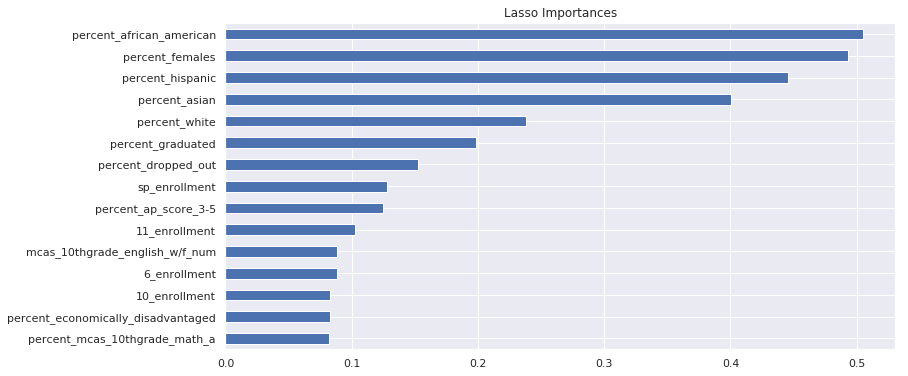

In [26]:
indices = np.argsort(lasso.coef_)[::-1]
lasso_imp_feat = []

for f in range(X.shape[1]):
    lasso_imp_feat.append(X.columns[indices[f]])

importances_df = pd.Series(lasso.coef_, index=X.columns)
importances_df.nlargest(15).sort_values().plot(kind='barh', figsize=(12, 6)) 
plt.title("Lasso Importances")
plt.show()

In [27]:
# Function to find common elements in n arrays 
def commonElements(arr): 
	
	# initialize result with first array as a set 
	result = set(arr[0]) 

	# now iterate through list of arrays starting from 
	# second array and take intersection_update() of 
	# each array with result. Every operation will 
	# update value of result with common values in 
	# result set and intersected set 
	for currSet in arr[1:]: 
		result.intersection_update(currSet) 

	return list(result) 

 
arr = [lasso_imp_feat[:50], xgb_imp_feat[:50], for_imp_feat[:50]] 
output = commonElements(arr) 
if len(output) > 0: 
	print (output, len(output))
else: 
	print ('No Common Elements Found')


['percent_asian', 'percent_graduated', 'average_sat_writing', 'percent_mcas_10thgrade_math_p+a', '12_enrollment', '10_enrollment', 'ap_test_takers', 'percent_mcas_10thgrade_math_a', 'percent_ap_score_3-5', 'average_salary', 'average_sat_reading', 'percent_african_american', 'sat_tests_taken', 'percent_females', 'students_with_disabilities', 'mcas_10thgrade_math_cpi', 'average_sat_math'] 17


In [28]:
output 

['percent_asian',
 'percent_graduated',
 'average_sat_writing',
 'percent_mcas_10thgrade_math_p+a',
 '12_enrollment',
 '10_enrollment',
 'ap_test_takers',
 'percent_mcas_10thgrade_math_a',
 'percent_ap_score_3-5',
 'average_salary',
 'average_sat_reading',
 'percent_african_american',
 'sat_tests_taken',
 'percent_females',
 'students_with_disabilities',
 'mcas_10thgrade_math_cpi',
 'average_sat_math']

In [0]:
X_for = X[list(for_imp_feat)]

X_xgb = X[list(xgb_imp_feat)]

X_lasso =X[list(lasso_imp_feat)]

X_out =X[list(output)]

In [30]:
X_train_for, X_test_for, y_train_for, y_test_for = train_test_split(X_for, y, test_size=0.2, random_state=1)
y_train_for.shape

X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X_xgb, y, test_size=0.2, random_state=1)
y_train_xgb.shape

X_train_lasso, X_test_lasso, y_train_lasso, y_test_lasso = train_test_split(X_lasso, y, test_size=0.2, random_state=1)
y_train_lasso.shape

X_train_out, X_test_out, y_train_out, y_test_out = train_test_split(X_out, y, test_size=0.2, random_state=1)
y_train_out.shape


(262,)

In [31]:
alpha_list = [.85, .9, .95]
parameters = {'alpha': alpha_list,
                    'fit_intercept': [False], 
                    'normalize' :[True], 'max_iter':[25, 50, 100, 150, 200, 300, 350]}
for_lasso_grid = GridSearchCV(lasso, parameters, cv=kfolds, scoring='neg_mean_squared_error')
for_lasso_grid.fit(X_train_for,y_train_for)



GridSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=False),
       error_score='raise-deprecating',
       estimator=Lasso(alpha=0.9, copy_X=True, fit_intercept=False, max_iter=300,
   normalize=True, positive=False, precompute=False, random_state=1,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'alpha': [0.85, 0.9, 0.95], 'fit_intercept': [False], 'normalize': [True], 'max_iter': [25, 50, 100, 150, 200, 300, 350]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [32]:
for_lasso_grid.best_estimator_

Lasso(alpha=0.95, copy_X=True, fit_intercept=False, max_iter=50,
   normalize=True, positive=False, precompute=False, random_state=1,
   selection='cyclic', tol=0.0001, warm_start=False)

In [33]:
-(for_lasso_grid.best_score_)

75.88092847744097

In [34]:
alpha_list = [.85, .9, .95]
parameters = {'alpha': alpha_list,
                    'fit_intercept': [False], 
                    'normalize' :[True], 'max_iter':[25, 50, 100, 150, 200, 300, 350]}
xgb_lasso_grid = GridSearchCV(lasso, parameters, cv=kfolds, scoring='neg_mean_squared_error')
xgb_lasso_grid.fit(X_train_xgb,y_train_xgb)

GridSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=False),
       error_score='raise-deprecating',
       estimator=Lasso(alpha=0.9, copy_X=True, fit_intercept=False, max_iter=300,
   normalize=True, positive=False, precompute=False, random_state=1,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'alpha': [0.85, 0.9, 0.95], 'fit_intercept': [False], 'normalize': [True], 'max_iter': [25, 50, 100, 150, 200, 300, 350]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [35]:
xgb_lasso_grid.best_estimator_

Lasso(alpha=0.95, copy_X=True, fit_intercept=False, max_iter=50,
   normalize=True, positive=False, precompute=False, random_state=1,
   selection='cyclic', tol=0.0001, warm_start=False)

In [36]:
-(xgb_lasso_grid.best_score_)

76.31263340777832

In [45]:
alpha_list = [.85, .9, .95]
parameters = {'alpha': alpha_list,
                    'fit_intercept': [False], 
                    'normalize' :[True], 'max_iter':[25, 50, 100, 150, 200, 300, 350]}
out_lasso_grid = GridSearchCV(lasso, parameters, cv=kfolds, scoring='neg_mean_squared_error')
out_lasso_grid.fit(X_train_out,y_train_out)

GridSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=False),
       error_score='raise-deprecating',
       estimator=Lasso(alpha=0.9, copy_X=True, fit_intercept=False, max_iter=300,
   normalize=True, positive=False, precompute=False, random_state=1,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'alpha': [0.85, 0.9, 0.95], 'fit_intercept': [False], 'normalize': [True], 'max_iter': [25, 50, 100, 150, 200, 300, 350]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [46]:
-(out_lasso_grid.best_score_)

77.04767499917823

In [38]:
%%time

from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha = 0.5)

for_ridge_grid = GridSearchCV(ridge_reg, parameters, cv=kfolds, n_jobs=-1, scoring='neg_mean_squared_error')
for_ridge_grid.fit(X_train_for, y_train_for)





CPU times: user 162 ms, sys: 20.1 ms, total: 182 ms
Wall time: 2.07 s


In [39]:
-(for_ridge_grid.best_score_)

137.02993508485113

In [41]:
%%time

from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha = 0.5)

xgb_ridge_grid = GridSearchCV(ridge_reg, parameters, cv=kfolds, n_jobs=-1, scoring='neg_mean_squared_error')
xgb_ridge_grid.fit(X_train_xgb, y_train_xgb)



CPU times: user 166 ms, sys: 16 ms, total: 182 ms
Wall time: 2.42 s


In [42]:
-(xgb_ridge_grid.best_score_)

125.66261018354007

In [43]:
%%time

from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha = 0.5)

lasso_ridge_grid = GridSearchCV(ridge_reg, parameters, cv=kfolds, n_jobs=-1, scoring='neg_mean_squared_error')
lasso_ridge_grid.fit(X_train_lasso, y_train_lasso)



CPU times: user 141 ms, sys: 24.8 ms, total: 165 ms
Wall time: 2.01 s


In [44]:
-(lasso_ridge_grid.best_score_)

122.46917635195841

In [0]:
forest = RandomForestRegressor(max_depth=7,n_jobs=-1, random_state=1, n_estimators=100, verbose=0)
forest.fit(X, y)

parameters = {'max_depth': ['2', '4', '6', '7','8'], 'max_leaf_nodes': ['None' , '2', '4', '5', '7', '10'] }

for_forest_grid = GridSearchCV(forest,parameters, cv=kfolds, random_state = 1, 

In [0]:
bootstrap=True, criterion='mse', max_depth=7,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=1, verbose=0, warm_start=False)